In [18]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mne 
warnings.simplefilter(action='ignore', category=FutureWarning)

eeg_file = '/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/src/EEG.machinelearing_data_BRMH.csv'  
df = pd.read_csv(eeg_file)

DATA CLEANING AND INITIAL EXPLORATION

In [19]:
# What kind of information are we dealing with? let's get some intuition about the participants.

from src.data_visualization import visualize_non_eeg_data as visualize_non_eeg_data
visualize_non_eeg_data(df)


 Dataset Overview (Categorical Columns Only)
--------------------------------------------------
Categorical Data shape: (945, 8)

Column Names and Data Types:
no.                    int64
sex                   object
age                  float64
eeg.date              object
education            float64
IQ                   float64
main.disorder         object
specific.disorder     object
dtype: object

Missing Values:
no.                   0
sex                   0
age                   0
eeg.date              0
education            15
IQ                   13
main.disorder         0
specific.disorder     0
dtype: int64

Descriptive Statistics:
               no.  sex         age   eeg.date   education          IQ  \
count   945.000000  945  945.000000        945  930.000000  932.000000   
unique         NaN    2         NaN        722         NaN         NaN   
top            NaN    M         NaN  2018.7.17         NaN         NaN   
freq           NaN  601         NaN          5     

In [20]:
# We can see there are some missing values in the education and the IQ columns.
# Since there are 15 and 13 NaNs, numbers which are negligible to the 945 rows, we will fill each of the missing values with the average of the column.
from src.data_cleaning import fill_NaNs as fill_NaNs
cleaned_df = fill_NaNs(df,'education')
cleaned_df = fill_NaNs(df, 'IQ')

In [21]:
# Now let's look at the eeg part of the dataframe.
from src.data_visualization import visualize_eeg_data as visualize_eeg_data
visualize_eeg_data(df)


 Dataset Overview (EEG Columns Only)
--------------------------------------------------
EEG Data shape: (945, 1141)

First 5 rows (electrode columns only):
   AB.A.delta.a.FP1  AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  \
0         35.998557         21.717375        21.518280        26.825048   
1         13.425118         11.002916        11.942516        15.272216   
2         29.941780         27.544684        17.150159        23.608960   
3         21.496226         21.846832        17.364316        13.833701   
4         37.775667         33.607679        21.865556        21.771413   

   AB.A.delta.e.Fz  AB.A.delta.f.F4  AB.A.delta.g.F8  AB.A.delta.h.T3  \
0        26.611516        25.732649        16.563408        29.891368   
1        14.151570        12.456034         8.436832         9.975238   
2        27.087811        13.541237        16.523963        12.775574   
3        14.100954        13.100939        14.613650         8.063191   
4        22.854536        2

In [22]:
# Check that the df includes no NaNs.
from src.data_cleaning import check_missing_electrode_values as check_missing_electrode_values
check_missing_electrode_values(df)

# We've found that column 122 is full of NaNs, hence it doesn't contain any useful data. Let's delete the column.
cleaned_df = cleaned_df.dropna(axis=1, how='all')


Missing values in the following electrode columns:
Unnamed: 122    945
dtype: int64


In [23]:
# Run check_missing_electrode_values to insure there are no missing values in the dataframe.
check_missing_electrode_values(df)

Missing values in the following electrode columns:
Unnamed: 122    945
dtype: int64


In [24]:
# Drop all columns that start with 'COH' since they are not relevant to our analysis.
cleaned_df = cleaned_df.loc[:, ~cleaned_df.columns.str.startswith('COH')]

In [25]:
# Next, we'll remove any duplicate rows.
cleaned_df = cleaned_df.drop_duplicates()

# Standarize all of the categorical columns in df (by converting all text to lowercase and stripping any leading/trailing spaces).
from src.data_cleaning import standardize_categorical_columns as standardize_categorical_columns
cleaned_df = standardize_categorical_columns(cleaned_df)

# Check for outliers in the categorical columns. 
from src.data_cleaning import check_for_categorical_outliers as check_for_categorical_outliers
check_for_categorical_outliers(cleaned_df)


 No rare categories detected in categorical columns.


In [26]:
# Reformat the electrode columns from prefix.band.type.channel to band.channel.
from src.data_cleaning import reformat_electrode_columns as reformat_electrode_columns
cleaned_df = reformat_electrode_columns(cleaned_df)
print(cleaned_df.head())

   no. sex   age    eeg.date  education          IQ       main.disorder  \
0    1   m  57.0   2012.8.30   13.43871  101.580472  addictive disorder   
1    2   m  37.0    2012.9.6    6.00000  120.000000  addictive disorder   
2    3   m  32.0   2012.9.10   16.00000  113.000000  addictive disorder   
3    4   m  35.0   2012.10.8   18.00000  126.000000  addictive disorder   
4    5   m  36.0  2012.10.18   16.00000  112.000000  addictive disorder   

      specific.disorder  delta.FP1  delta.FP2  ...  gamma.Cz  gamma.C4  \
0  alcohol use disorder  35.998557  21.717375  ...  1.993727  1.765493   
1  alcohol use disorder  13.425118  11.002916  ...  0.903383  0.931967   
2  alcohol use disorder  29.941780  27.544684  ...  1.096713  1.691152   
3  alcohol use disorder  21.496226  21.846832  ...  1.115040  1.122776   
4  alcohol use disorder  37.775667  33.607679  ...  1.193191  2.320845   

   gamma.T4  gamma.T5  gamma.P3  gamma.Pz  gamma.P4  gamma.T6  gamma.O1  \
0  1.464281  1.501948  1.7073

In [27]:
# There aren't any categorical outliers in the categorical columns.
# We will leave all of the values in the eeg data columns because we don't wish to modify it. 

# Update the original dataframe, after the cleaning.
df = cleaned_df

# Save the cleaned data to a new csv file. 
df.to_csv('/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/cleaned_eeg_data.csv', index=False)


DATA ANALYSIS

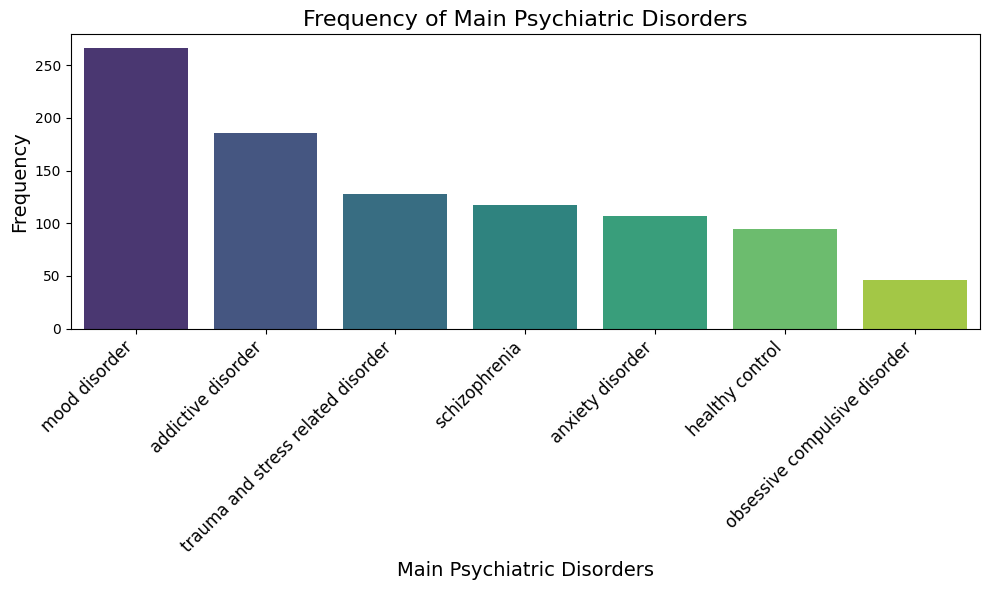

In [28]:
# Our main question is: what are the characteristic EEG activity of different main psychiatric disorders?
# Let's start by checking the distribution of the main psychiatric disorder column.
from src.data_visualization import visualize_main_psychiatric_disorders as visualize_main_psychiatric_disorders
visualize_main_psychiatric_disorders(df)

In [29]:
from src.data_analysis import calculate_band_averages as calculate_band_averages
# Choose an example main disorder.
main_disorder = "schizophrenia"
# Create a dictionary of average electrode activity in each band for schizophrenia. 
band_averages = calculate_band_averages(main_disorder, df)
# Display the result 
band_averages

{'delta': {'FP1': np.float64(21.537750615384613),
  'FP2': np.float64(22.64649011111111),
  'F7': np.float64(19.99249379487179),
  'F3': np.float64(19.890803615384613),
  'Fz': np.float64(21.009199905982904),
  'F4': np.float64(20.68371049572649),
  'F8': np.float64(18.344535794871792),
  'C3': np.float64(17.231452196581195),
  'Cz': np.float64(20.36609147863248),
  'C4': np.float64(18.3739221025641),
  'P3': np.float64(15.562961743589744),
  'Pz': np.float64(17.598650102564097),
  'P4': np.float64(17.89870036752137),
  'O1': np.float64(14.427239333333334),
  'O2': np.float64(14.78089847008547)},
 'theta': {'FP1': np.float64(13.491386282051284),
  'FP2': np.float64(14.186993623931622),
  'F7': np.float64(10.804500205128205),
  'F3': np.float64(15.219211051282054),
  'Fz': np.float64(17.65196651282051),
  'F4': np.float64(16.638378709401714),
  'F8': np.float64(11.565453495726498),
  'C3': np.float64(13.130086213675213),
  'Cz': np.float64(16.57298682051282),
  'C4': np.float64(14.24282

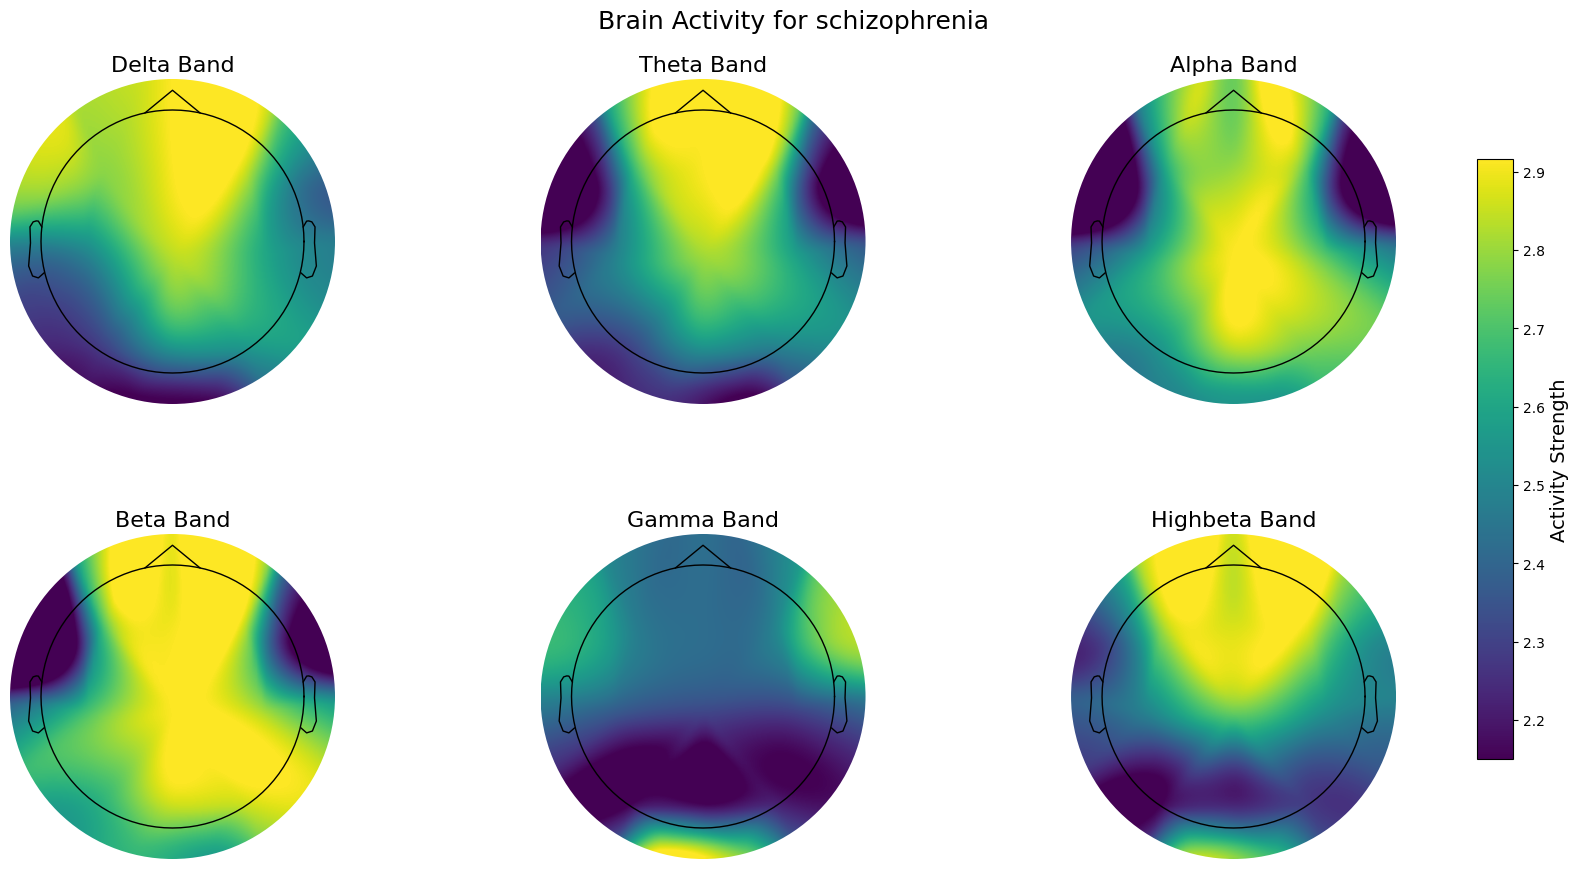

In [30]:
from src.data_visualization import visualize_brain_activity as visualize_brain_activity
# Visualize the brain activity for the given band averages in addictive disorder.
visualize_brain_activity(band_averages, main_disorder)

In [31]:
from src.data_analysis import find_significant_differences as find_significant_differences
hc = "healthy control"
main_disorder = "schizophrenia"
# Create a dictionary of average electrode activity in each band for healthy control. 
healthy_band_averages = calculate_band_averages(hc, df)
disorder_band_averages = calculate_band_averages(main_disorder, df)

significant_differences = find_significant_differences(df, main_disorder, hc,  p_threshold=0.0001, activity_type= "enhanced")
print(significant_differences)

{'delta': ['O1', 'O2'], 'theta': [], 'alpha': [], 'beta': ['FP1', 'FP2', 'Fz', 'F4', 'F8', 'C4', 'O1'], 'gamma': [], 'highbeta': []}


We see that schizophrenics have augmented activity in the occipital lobe, especially in the delta frequency band. 

It is interesting to note that the delta band is associated with low frequencies that promote sleep like states.

It is known that one of the main symptoms of schizophrenia is visual hallucinations, as occurs while dreaming. 

This statistic analysis and information can confirm that schizophrenics have 

In [32]:
# Visualize the EEG head maps for all disorders. 

from src.data_analysis import prepare_disorder_band_averages as prepare_disorder_band_averages
# Prepare the required arguments for the `visualize_all_disorders` function from the given dataset.
disorders = df['main.disorder'].unique().tolist()
frequency_bands = ["delta", "theta", "alpha", "beta", "gamma", "highbeta"]
electrodes = ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 
              'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

# Generate the required arguments
disorder_band_averages, disorder_names = prepare_disorder_band_averages(df, disorders, frequency_bands, electrodes)

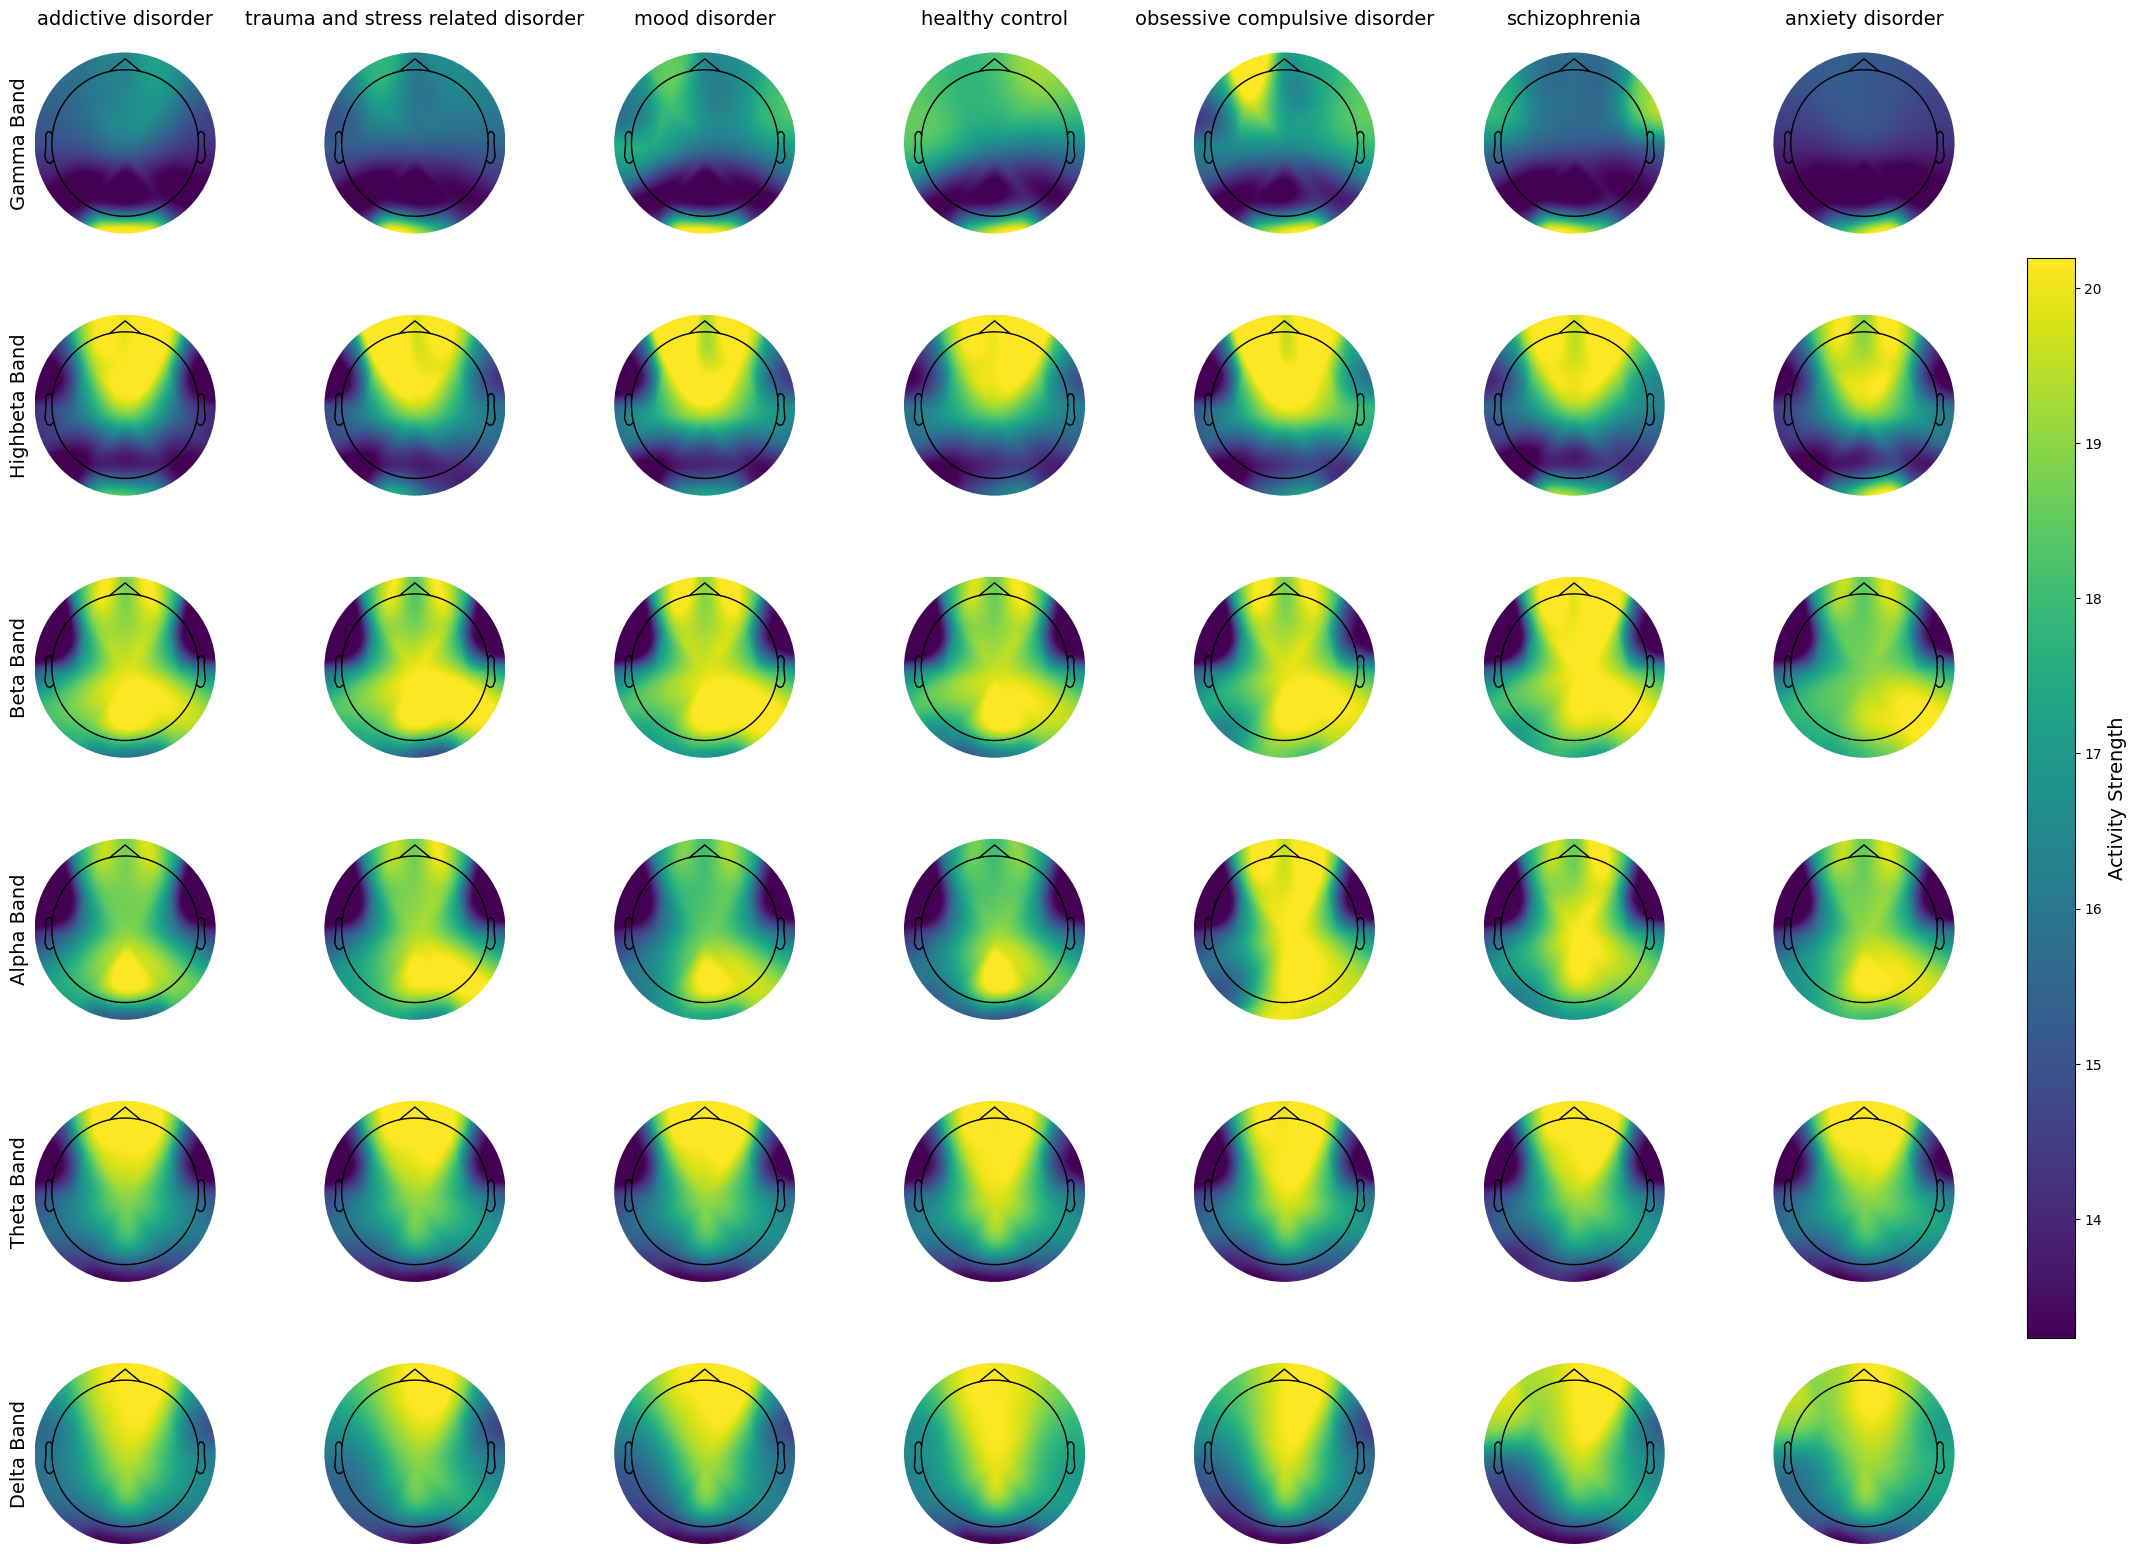

In [33]:
# Visualize the brain activity for all main disorders in the dataset.
from src.data_visualization import visualize_all_disorders as visualize_all_disorders
visualize_all_disorders(disorder_band_averages, disorder_names)

# The strength of of the EEG activity is normalized compared to the minimun and maximun values of the band averages. 

In [34]:
# Can we predict the main psychiatric disorder based on the EEG data?

from src.data_preprocessing import split_data, train_model, evaluate_model, preprocess_data

# Running the pipeline
df_processed, label_encoders = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(df_processed)
rf_model = train_model(X_train, y_train)
accuracy, classification_rep = evaluate_model(rf_model, X_test, y_test, label_encoders["main.disorder"])

# Convert classification report dictionary to a DataFrame
classification_df = pd.DataFrame.from_dict(classification_rep).transpose()

# Print accuracy and classification report as a formatted table
print(f"\nModel Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_df.to_string()) 


Model Accuracy: 0.37

Classification Report:
                                    precision    recall  f1-score     support
addictive disorder                   0.312500  0.441176  0.365854   34.000000
anxiety disorder                     0.375000  0.187500  0.250000   16.000000
healthy control                      0.333333  0.052632  0.090909   19.000000
mood disorder                        0.390476  0.732143  0.509317   56.000000
obsessive compulsive disorder        0.000000  0.000000  0.000000    9.000000
schizophrenia                        0.166667  0.100000  0.125000   20.000000
trauma and stress related disorder   0.538462  0.200000  0.291667   35.000000
accuracy                             0.365079  0.365079  0.365079    0.365079
macro avg                            0.302348  0.244779  0.233249  189.000000
weighted avg                         0.354521  0.365079  0.314267  189.000000


/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/.venv/lib/python